In [1]:
import itertools #iteration tools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # nice plots
import matplotlib.pyplot as plt # plots
from sklearn.linear_model import LogisticRegression # machine learning

### Get train Data

In [2]:
train_df = pd.read_csv(r'C:/Users/ernest.chocholowski/Desktop/Datasets/Titanic/train.csv')
test_df = pd.read_csv(r'C:/Users/ernest.chocholowski/Desktop/Datasets/Titanic/test.csv')
both_df = [train_df, test_df]
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Early analysis

#### Features analysis

**First I check categories**

In [3]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


**Then - which types of features are those?**

**Categorical: (change, but only between some categories)**
- Nominal: Survived, Sex, Embarked 
- Ordinal: Pclass

**Numerical: (change from sample to sample)**
- Continous: Age, Fare
- Discrete: SibSP, Parch

**Mixed types: (alphanumeric+numeric)**:
- Ticket, Cabin

#### Data Quality checks

To look for any null values I use isnull call:

In [4]:
train_df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

Now we know, that we sometimes lack information about passenger age, their assigned cabin, and where they have embarked.

In [5]:
test_df.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

Some of test data has no Age, Cabin or Fare information!

#### Closer look
Let's check what are types of our data, how much non-null entries do we have in each column etc.

In [6]:
train_df.info()
print('_'*50)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         41

Now we know some more: 
- we are severly lacking cabin information
- we lack only very few information about embarkation in our test data
- 5 features of int type, 2 of float type (one less in test dataset, because we lack survivality information)
- 5 features of string type (objects)

#### Very close look
Let's check numerical features of given datasettrain_df.describe()

In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Mostly young people (75% up to 38 y.o.)
- Most of the people with low-class tickets
- Most passengers (>75%) travelled with no children, and some with siblings/spouse (~0.5 per capita)
- Ticket fares differed significantly

### Further analysis

#### Assumptions
- Probably woman, children were more likely to survive (evacuation priority)
- Probably rich people were more likely to survive (evacuation priority)
- Probably young (fit) people were more likely to survive?
- "Big family" syndrome could have affected survivality? ("I don't go without my brother/sister/child/wife/duck!")

In [8]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Pclass', ascending=True)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Sex', ascending=True)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Let's group ages by 5-year groups for simplicity

In [10]:
train_df[["Age", "Survived"]].groupby(train_df.Age//5, as_index=False).mean().sort_values(by='Age', ascending=True)

,Age,Survived
0,2.254250,0.675000
1,7.409091,0.500000
2,12.531250,0.437500
3,17.569767,0.395349
4,22.206140,0.342105
5,27.037736,0.358491
6,31.773684,0.421053
7,36.729167,0.458333
8,41.750000,0.375000
9,46.780488,0.390244


In [11]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='SibSp', ascending=True)

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Parch', ascending=True)

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


We've found significant correlation between sex, wealth and survival, while no significant correlation between SibSp, Parch and Age categories and survival (besides significant drop at certain age and significant rise for low age).

#### Visual evaluation of Age-survivality relation
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

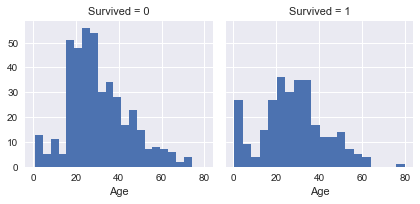

In [13]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

Now it leaves absolutely no doubt, that some age grups were more potent to die than the others. Let's complete Age feature and consider it in model training. For that we should band some age groups.

#### Visual evaluation of Class-Age corelation with Survivalitygrid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

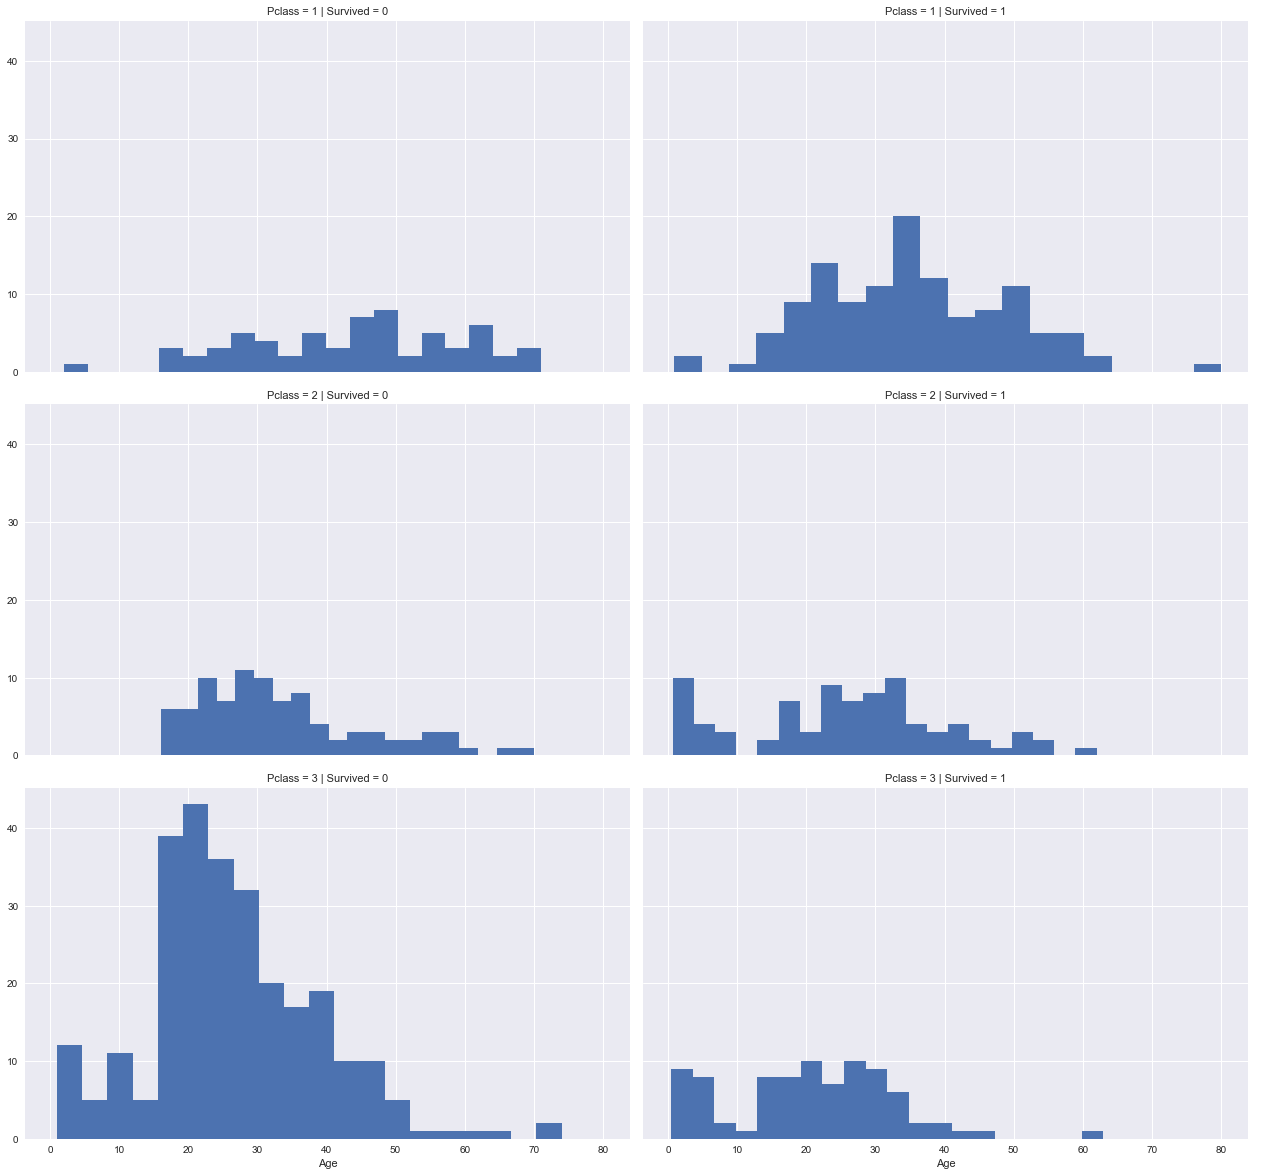

In [14]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=5.5, aspect=1.6)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend();
plt.show()

- Infants have mostly survived, regardless of social class (but there are some casualities in Pclass=3). 
- Pclass 3 had the most passengers but also the highest mortality.
- Most of Pclass 1 survived.

Pclass seems to be proven great candidate for model trainings, along with age categories.

#### Visual evaluation of gender influence by social class and embarkation place

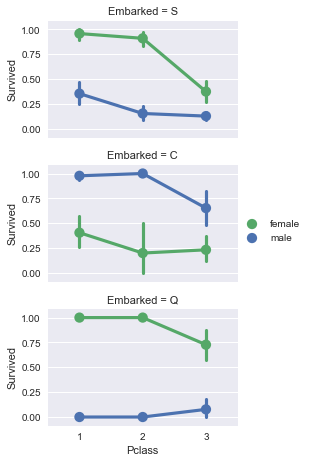

In [15]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()
plt.show()

Sex seems to be good categorizer for survivality, with the only exception being for those embarked in location C. Since numerical analysis suggest strong sex-survivality correlation, this oddity may suggest some bias in passenger group in embark-location C (significantly more men from high social class than women?).

### Data preparation
#### Dropping useless values and refactoring some useful ones

In [16]:
print("Before", train_df.shape, test_df.shape, both_df[0].shape, both_df[1].shape)
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
both_df = [train_df, test_df]
print("After", train_df.shape, test_df.shape, both_df[0].shape, both_df[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


Keep in mind that the Name is not dropped, as I want to extract title from it, to check if it has any significance.

Let's create new column in dataset, named "Title", out of the "Name" column.

In [17]:
for dataset in both_df:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


There is way too many useless one-timer titles and variants of same title. Let's merge them.

In [18]:
for df in both_df:
    df['Title'] = df['Title'].replace([
                                        'Lady', 'Countess', 'Capt', 'Col',\
                                        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [19]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [20]:
train_df[['Title', 'Age']].groupby(['Title'], as_index=False).mean()

,Title,Age
0,Master,4.574167
1,Miss,21.845638
2,Mr,32.368090
3,Mrs,35.788991
4,Rare,45.545455


Master is clearly children's title, rare titles are little older. Should be usefull for model training. Let's transform it to ordinal value then.

In [21]:
titles = {'Mr': 1, 'Rare': 2, 'Master': 3, 'Miss': 4, 'Mrs': 5}
for df in both_df:
    df['Title'] = df['Title'].map(titles)
    df['Title'] = df['Title'].fillna(0)

Would be nice to change sex information in the same way:

In [22]:
for df in both_df:
    df['Sex'] = df['Sex'].map({'female':1, 'male':0}).astype(int)

In [23]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,5
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,5
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,1


Name is useless now though.

In [24]:
train_df = train_df.drop(['Name','PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
both_df = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

In [25]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,5
2,1,3,1,26.0,0,0,7.9250,S,4
3,1,1,1,35.0,1,0,53.1000,S,5
4,0,3,0,35.0,0,0,8.0500,S,1


#### Completing missing values

In [26]:
#Preparing matrix 2x3 for guessed age medians, depending on Social Class (Pclass) and Gender
ages = np.zeros((2,3))

In [27]:
for df in both_df:
    for i, j in itertools.product(range(2), range(3)):
        ages_df = df[(df['Sex'] == i) & \
                    (df['Pclass'] == j+1)]['Age'].dropna()
        #####other option####
        # ages_mean = ages_df.mean()
        # ages_std = ages_df.std()
        # ages_guess = rnd.uniform(ages_mean-ages_std, ages_mean+ages_std)
        #####################
        ages_guess = ages_df.median()
        ages[i,j] = int(ages_guess/0.5+0.5)*0.5 #brought to nearest 0.5 year old age
    for i, j in itertools.product(range(2), range(3)):
        df.loc[(df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1), 'Age'] = ages[i, j]
    df['Age'] = df['Age'].astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,5
2,1,3,1,26,0,0,7.9250,S,4
3,1,1,1,35,1,0,53.1000,S,5
4,0,3,0,35,0,0,8.0500,S,1


Try to determiny some legit age bands:

In [28]:
train_df['AgeCat'] = pd.cut(train_df['Age'], 10)
train_df[['AgeCat', 'Survived']].groupby(['AgeCat'], as_index=False).mean().sort_values(by='AgeCat', ascending=True)

,AgeCat,Survived
0,"(-0.08, 8.0]",0.666667
1,"(8.0, 16.0]",0.413043
2,"(16.0, 24.0]",0.400000
3,"(24.0, 32.0]",0.287273
4,"(32.0, 40.0]",0.439189
5,"(40.0, 48.0]",0.352941
6,"(48.0, 56.0]",0.466667
7,"(56.0, 64.0]",0.375000
8,"(64.0, 72.0]",0.000000
9,"(72.0, 80.0]",0.500000


Seems okay - let's replace Age with AgeCat

In [29]:
for df in both_df:
    df.loc[ df['Age'] <= 8, 'Age'] = 0
    df.loc[(df['Age'] > 8) & (df['Age'] <= 16), 'Age'] = 1
    df.loc[(df['Age'] > 16) & (df['Age'] <= 24), 'Age'] = 2
    df.loc[(df['Age'] > 24) & (df['Age'] <= 32), 'Age'] = 3
    df.loc[(df['Age'] > 32) & (df['Age'] <= 40), 'Age'] = 4
    df.loc[(df['Age'] > 40) & (df['Age'] <= 48), 'Age'] = 5
    df.loc[(df['Age'] > 48) & (df['Age'] <= 56), 'Age'] = 6
    df.loc[(df['Age'] > 56) & (df['Age'] <= 64), 'Age'] = 7
    df.loc[(df['Age'] > 64) & (df['Age'] <= 72), 'Age'] = 8
    df.loc[ df['Age'] > 72, 'Age'] = 9
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeCat
0,0,3,0,2,1,0,7.2500,S,1,"(16.0, 24.0]"
1,1,1,1,4,1,0,71.2833,C,5,"(32.0, 40.0]"
2,1,3,1,3,0,0,7.9250,S,4,"(24.0, 32.0]"
3,1,1,1,4,1,0,53.1000,S,5,"(32.0, 40.0]"
4,0,3,0,4,0,0,8.0500,S,1,"(32.0, 40.0]"


Now we don't need *AgeCat* anymore:

In [30]:
train_df = train_df.drop(['AgeCat'], axis=1)
both_df = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,2,1,0,7.2500,S,1
1,1,1,1,4,1,0,71.2833,C,5
2,1,3,1,3,0,0,7.9250,S,4
3,1,1,1,4,1,0,53.1000,S,5
4,0,3,0,4,0,0,8.0500,S,1


**New feature as a comination of existing ones**

In [31]:
for df in both_df:
    df['FamSize'] = df['SibSp']+df['Parch']+1
    
train_df[['FamSize', 'Survived']].groupby(['FamSize'], as_index=False).mean().sort_values(by='Survived', ascending=False)   

,FamSize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [32]:
for df in both_df:
    df['IsAlone'] = 0
    df.loc[df['FamSize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Being alone there lowers our survivality chance, while being with family, regardless the size, brings the results back to toss of a coin. Different sizes of the families have very different survivality chances, though it may be small sample size and we observe no strong linear correlation between *FamSize* and Survivality


Anyway, *Parch, SibSp, FamSize* will be dropped in favour of isAlone (as it seems to be nice indicator).

In [33]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamSize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamSize'], axis=1)
both_df = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,2,7.2500,S,1,0
1,1,1,1,4,71.2833,C,5,0
2,1,3,1,3,7.9250,S,4,1
3,1,1,1,4,53.1000,S,5,0
4,0,3,0,4,8.0500,S,1,1


Moreover, let's try to combine Age and Class features, to check if we can simplify dataset:

In [34]:
for df in both_df:
    df['Age*Class'] = (df.Age+1) * df.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,9,2,3
1,5,4,1
2,12,3,3
3,5,4,1
4,15,4,3
5,12,3,3
6,7,6,1
7,3,0,3
8,12,3,3
9,4,1,2


In [35]:
train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=False).mean()

,Age*Class,Survived
0,1,0.666667
1,2,1.000000
2,3,0.625000
3,4,0.666667
4,5,0.638889
5,6,0.430000
6,7,0.592593
7,8,0.407895
8,9,0.303797
9,10,0.454545


Yes, this seems to work well for our purpose.

Let's check if we still have any values missing:

In [36]:
train_df.info()
print('_'*50)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int32
Age          891 non-null int32
Fare         891 non-null float64
Embarked     889 non-null object
Title        891 non-null int64
IsAlone      891 non-null int64
Age*Class    891 non-null int64
dtypes: float64(1), int32(2), int64(5), object(1)
memory usage: 55.8+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int32
Age            418 non-null int32
Fare           417 non-null float64
Embarked       418 non-null object
Title          418 non-null int64
IsAlone        418 non-null int64
Age*Class      418 non-null int64
dtypes: float64(1), int32(2), int64(5), object(1)
memory usage: 26.2

Okay, we still need 1 information about *Fare* and 3 informations about *Embarkation*. Since these are not pivotal values, and we lack only very few of them, we will force the values with either most frequent one or median.

In [37]:
freq_port = train_df.Embarked.dropna().mode()[0]
for df in both_df:
    df['Embarked'] = df['Embarked'].fillna(freq_port)
for df in both_df:
    df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [38]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,4,7.8292,2,1,1,15
1,893,3,1,5,7.0000,0,5,0,18
2,894,2,0,7,9.6875,2,1,1,16
3,895,3,0,3,8.6625,0,1,1,12
4,896,3,1,2,12.2875,0,5,0,9


As these informations are not pivotal, but may be usefull, let's force them into one value. For this purpose we also need to categorize *Fare* into *FareBand*.

In [39]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
for df in both_df:
    df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[ df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
both_df = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,2,0,0,1,0,9
1,1,1,1,4,3,1,5,0,5
2,1,3,1,3,1,0,4,1,12
3,1,1,1,4,3,0,5,0,5
4,0,3,0,4,1,0,1,1,15


In [40]:
for df in both_df:
    df['FareEmbarked'] = (df.Fare+1) * (df.Embarked+1)

train_df.loc[:, ['FareEmbarked', 'Fare', 'Embarked']].head(10)

,FareEmbarked,Fare,Embarked
0,1,0,0
1,8,3,1
2,2,1,0
3,4,3,0
4,2,1,0
5,6,1,2
6,4,3,0
7,3,2,0
8,2,1,0
9,6,2,1


In [41]:
train_df[['FareEmbarked', 'Survived']].groupby(['FareEmbarked'], as_index=False).mean()

,FareEmbarked,Survived
0,1,0.115942
1,2,0.273504
2,3,0.441315
3,4,0.515924
4,6,0.454545
5,8,0.743243
6,9,0.333333
7,12,0.500000


In [42]:
train_df = train_df.drop(['Fare', 'Embarked'], axis=1)
test_df = test_df.drop(['Fare', 'Embarked'], axis=1)
both_df = [train_df, test_df]

In [43]:
train_df.head(10)

,Survived,Pclass,Sex,Age,Title,IsAlone,Age*Class,FareEmbarked
0,0,3,0,2,1,0,9,1
1,1,1,1,4,5,0,5,8
2,1,3,1,3,4,1,12,2
3,1,1,1,4,5,0,5,4
4,0,3,0,4,1,1,15,2
5,0,3,0,3,1,1,12,6
6,0,1,0,6,1,1,7,4
7,0,3,0,0,3,0,3,3
8,1,3,1,3,5,0,12,2
9,1,2,1,1,5,0,4,6


### Modelling, predicting, fitting

In [44]:
train_df.head(10)

,Survived,Pclass,Sex,Age,Title,IsAlone,Age*Class,FareEmbarked
0,0,3,0,2,1,0,9,1
1,1,1,1,4,5,0,5,8
2,1,3,1,3,4,1,12,2
3,1,1,1,4,5,0,5,4
4,0,3,0,4,1,1,15,2
5,0,3,0,3,1,1,12,6
6,0,1,0,6,1,1,7,4
7,0,3,0,0,3,0,3,3
8,1,3,1,3,5,0,12,2
9,1,2,1,1,5,0,4,6


In [45]:
# learning set
X_train = train_df.drop("Survived", axis=1)
# answers for learning set
Y_train = train_df["Survived"]
# testing set
X_test  = test_df.drop("PassengerId", axis=1).copy()

X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution

In [63]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
logreg.coef_

array([[-1.05952285,  0.03232642, -0.2059655 ,  0.86369699,  0.6053184 ,
        -0.0297294 ,  0.0645671 ]])

In [64]:
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

81.480000000000004

### Test data!

In [51]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv(r'C:/Users/ernest.chocholowski/Desktop/Datasets/Titanic/output/submission_logreg1.csv', index=False)